In [1]:
%load_ext autoreload
%autoreload 2

import seaborn as sns
import metapack as mp
import pandas as pd
import geopandas as gpd
import numpy as np
import rowgenerators as rg
import matplotlib.pyplot as plt
from IPython.display import display 

%matplotlib inline
sns.set_context('notebook')
mp.jupyter.init()


In [2]:
#pkg = mp.jupyter.open_package()
pkg = mp.jupyter.open_source_package()
pkg

# Safegraph Patterns Data
`safegraph.com-patterns-1.1.1` Last Update: 2021-09-29T15:37:57

__




 

## Contacts

* **Wrangler** [Eric Busboom](mailto:eric@civicknowledge.com), [Civic Knowledge](http://civicknowledge.com)


## References
<ul><li> <strong>sdsm-patterns-202106</string>, <em>data/SanDiego-Carlsbad-SanMarcosCAMSA-7224-722513-447110-PATTERNS-2021_06-2021-09-29.zip#patterns.csv</em>. </li><li> <strong>sdsm-visit-202106</string>, <em>data/SanDiego-Carlsbad-SanMarcosCAMSA-7224-722513-447110-PATTERNS-2021_06-2021-09-29.zip#visit_panel_summary.csv</em>. </li><li> <strong>sdsm-norm-202106</string>, <em>data/SanDiego-Carlsbad-SanMarcosCAMSA-7224-722513-447110-PATTERNS-2021_06-2021-09-29.zip#normalization_stats.csv</em>. </li><li> <strong>sdsm-home-202106</string>, <em>data/SanDiego-Carlsbad-SanMarcosCAMSA-7224-722513-447110-PATTERNS-2021_06-2021-09-29.zip#home_panel_summary.csv</em>. </li><li> <strong>sdsm-patterns-202107</string>, <em>data/SanDiego-Carlsbad-SanMarcosCAMSA-7224-722513-447110-PATTERNS-2021_07-2021-09-29.zip#patterns.csv</em>. </li><li> <strong>sdsm-visit-202107</string>, <em>data/SanDiego-Carlsbad-SanMarcosCAMSA-7224-722513-447110-PATTERNS-2021_07-2021-09-29.zip#visit_panel_summary.csv</em>. </li><li> <strong>sdsm-norm-202107</string>, <em>data/SanDiego-Carlsbad-SanMarcosCAMSA-7224-722513-447110-PATTERNS-2021_07-2021-09-29.zip#normalization_stats.csv</em>. </li><li> <strong>sdsm-home-202107</string>, <em>data/SanDiego-Carlsbad-SanMarcosCAMSA-7224-722513-447110-PATTERNS-2021_07-2021-09-29.zip#home_panel_summary.csv</em>. </li><li> <strong>sdsm-patterns-202108</string>, <em>data/SanDiego-Carlsbad-SanMarcosCAMSA-7224-722513-447110-PATTERNS-2021_08-2021-09-29.zip#patterns.csv</em>. </li><li> <strong>sdsm-visit-202108</string>, <em>data/SanDiego-Carlsbad-SanMarcosCAMSA-7224-722513-447110-PATTERNS-2021_08-2021-09-29.zip#visit_panel_summary.csv</em>. </li><li> <strong>sdsm-norm-202108</string>, <em>data/SanDiego-Carlsbad-SanMarcosCAMSA-7224-722513-447110-PATTERNS-2021_08-2021-09-29.zip#normalization_stats.csv</em>. </li><li> <strong>sdsm-home-202108</string>, <em>data/SanDiego-Carlsbad-SanMarcosCAMSA-7224-722513-447110-PATTERNS-2021_08-2021-09-29.zip#home_panel_summary.csv</em>. </li><li> <strong>sdsm-brands</string>, <em>data/SanDiego-Carlsbad-SanMarcosCAMSA-7224-722513-447110-CORE_POI-2021_08-2021-09-29.zip#brand_info.csv</em>. </li><li> <strong>sdsm-poi</string>, <em>data/SanDiego-Carlsbad-SanMarcosCAMSA-7224-722513-447110-CORE_POI-2021_08-2021-09-29.zip#core_poi.csv</em>. </li><ul>

In [3]:
bg = rg.geoframe("censusgeo://CA/blockgroup")

In [4]:
poi = pkg.reference('sdsm-poi').dataframe()

In [171]:
# Read all of the zip file and extract some of the CSVs
from pathlib import Path
import zipfile
from collections import defaultdict 
frames = defaultdict(list)

for f in list(Path(pkg.ref.fspath.parent.joinpath('data')).glob('**/*.zip')):
    
    archive = zipfile.ZipFile(f, 'r')
    for name in archive.namelist():
        if name in ['core_poi.csv','patterns.csv','core_poi-patterns.csv']:
            frames[name].append(pd.read_csv(archive.open(name)))


In [203]:
# Combine the POI and pattern files we got seperately with the 
# ones that are already combined. 
cp = pd.concat(frames['core_poi.csv'])

pat = pd.concat(frames['patterns.csv'])

drops = set(cp.columns).intersection(set(pat.columns)) - set(['placekey'])

cpp = pd.concat(frames['core_poi-patterns.csv'])
print(cpp.shape)

cppj = cp.merge(pat.drop(columns=drops))[cpp.columns]
print(cppj.shape)


df = pd.concat([cpp, cppj])


def make_geoid(cbg):
    try:
        return '15000US'+cbg.astype('str').str.zfill(12)
    except AttributeError:
        return '15000US'+cbg.zfill(12)


df['geoid'] = make_geoid(df.poi_cbg)
df['geometry'] = gpd.points_from_xy(df.longitude, df.latitude, crs="EPSG:4326")

df = gpd.GeoDataFrame(df)

df['year'] = pd.to_datetime(df.date_range_start).dt.year
df['month'] = pd.to_datetime(df.date_range_start).dt.month
df['date'] = pd.to_datetime(df.date_range_start).dt.date

df = df.reset_index(drop=True)
df['place_id'] = df.index

(1115, 40)
(10446, 40)


In [204]:
df.sub_category.value_counts()

Limited-Service Restaurants                  5827
Gasoline Stations with Convenience Stores    2559
Drinking Places (Alcoholic Beverages)        2060
Snack and Nonalcoholic Beverage Bars          884
Department Stores                              87
All Other General Merchandise Stores           81
Hardware Stores                                63
Name: sub_category, dtype: int64

In [228]:
df[df.sub_category == 'Snack and Nonalcoholic Beverage Bars'].head().T

,1,2,3,4,5
placekey,222-223@5z5-wwk-4qf,zzy-222@5z5-pnc-v75,223-223@5z5-qcd-y7q,222-222@5z5-qx4-rc5,zzw-222@5z5-s7y-zj9
parent_placekey,222-222@5z5-wwk-4qf,NaN,223-222@5z5-qcd-y7q,NaN,NaN
location_name,Starbucks,Starbucks,Starbucks,Starbucks,Starbucks
safegraph_brand_ids,SG_BRAND_f116acfe9147494063e58da666d1d57e,SG_BRAND_f116acfe9147494063e58da666d1d57e,SG_BRAND_f116acfe9147494063e58da666d1d57e,SG_BRAND_f116acfe9147494063e58da666d1d57e,SG_BRAND_f116acfe9147494063e58da666d1d57e
brands,Starbucks,Starbucks,Starbucks,Starbucks,Starbucks
top_category,Restaurants and Other Eating Places,Restaurants and Other Eating Places,Restaurants and Other Eating Places,Restaurants and Other Eating Places,Restaurants and Other Eating Places
sub_category,Snack and Nonalcoholic Beverage Bars,Snack and Nonalcoholic Beverage Bars,Snack and Nonalcoholic Beverage Bars,Snack and Nonalcoholic Beverage Bars,Snack and Nonalcoholic Beverage Bars
category_tags,"Snacks,Counter Service,Dessert,Tea House,Coffe...","Snacks,Counter Service,Dessert,Tea House,Coffe...","Snacks,Counter Service,Dessert,Tea House,Coffe...","Snacks,Counter Service,Dessert,Tea House,Coffe...","Snacks,Counter Service,Dessert,Tea House,Coffe..."
naics_code,722515,722515,722515,722515,722515
latitude,32.646073,32.831115,32.79235,33.159143,32.820354


In [211]:

t = df[['placekey','naics_code','sub_category','date','raw_visit_counts','distance_from_home','median_dwell', 'geometry']]

rvc = t.groupby('placekey')[['raw_visit_counts','distance_from_home','median_dwell']].mean()
x = t.groupby('placekey')[['naics_code','sub_category','geometry']].first()
poiv = x.join(rvc)
poiv.head()


,naics_code,sub_category,geometry,raw_visit_counts,distance_from_home,median_dwell
placekey,,,,,,
222-222@5z5-pmd-p5f,447110,Gasoline Stations with Convenience Stores,POINT (-117.23562 32.80063),6.000000,12018.500000,13.500000
222-222@5z5-pmf-d5f,722515,Snack and Nonalcoholic Beverage Bars,POINT (-117.23928 32.79780),473.666667,25061.333333,7.666667
222-222@5z5-pmj-bhq,722513,Limited-Service Restaurants,POINT (-117.21887 32.80893),2089.000000,25830.666667,20.000000
222-222@5z5-pmj-f4v,722410,Drinking Places (Alcoholic Beverages),POINT (-117.21972 32.80617),139.666667,19338.333333,17.333333
222-222@5z5-pn3-92k,722513,Limited-Service Restaurants,POINT (-117.16348 32.83300),535.333333,14507.333333,9.000000


In [230]:
poiv[poiv.sub_category ==  'Snack and Nonalcoholic Beverage Bars'].raw_visit_counts.sum()

115446.83333333333

In [236]:
t = poiv[['sub_category','raw_visit_counts']].set_index('sub_category', append=True).unstack().round(0).astype('Int64')
print(t.columns)
t.columns = ['gen_store','dept_store','bars','gas_conveniece','hardware','ls_restaurants','snack_bev']
raster_df = df[['placekey','geometry']].drop_duplicates().set_index('placekey').join(t)

MultiIndex([('raw_visit_counts',      'All Other General Merchandise Stores'),
            ('raw_visit_counts',                         'Department Stores'),
            ('raw_visit_counts',     'Drinking Places (Alcoholic Beverages)'),
            ('raw_visit_counts', 'Gasoline Stations with Convenience Stores'),
            ('raw_visit_counts',                           'Hardware Stores'),
            ('raw_visit_counts',               'Limited-Service Restaurants'),
            ('raw_visit_counts',      'Snack and Nonalcoholic Beverage Bars')],
           names=[None, 'sub_category'])


In [237]:
raster_df.sum()

gen_store         153438
dept_store         74183
bars              123278
gas_conveniece    319796
hardware           67979
ls_restaurants    581226
snack_bev         141053
dtype: int64

In [238]:
utm_bands_buffered = rg.geoframe('metapack+http://s3.amazonaws.com/radius.civicknowledge.com/civicknowledge.com-mgrs.csv#utm_bands_buffered')


/Users/eric/opt/anaconda3/envs/radius38/lib/python3.8/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


In [239]:
raster_df =  gpd.sjoin(gpd.GeoDataFrame(raster_df, crs=4326),utm_bands_buffered.to_crs(4326)).drop(columns='index_right')
raster_df

,geometry,gen_store,dept_store,bars,gas_conveniece,hardware,ls_restaurants,snack_bev,band
placekey,,,,,,,,,
222-222@5z5-pmd-p5f,POINT (-117.23562 32.80063),<NA>,<NA>,<NA>,6,<NA>,<NA>,<NA>,11
222-222@5z5-pmf-d5f,POINT (-117.23928 32.79780),<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,474,11
222-222@5z5-pmj-bhq,POINT (-117.21887 32.80893),<NA>,<NA>,<NA>,<NA>,<NA>,2089,<NA>,11
222-222@5z5-pmj-f4v,POINT (-117.21972 32.80617),<NA>,<NA>,140,<NA>,<NA>,<NA>,<NA>,11
222-222@5z5-pn3-92k,POINT (-117.16348 32.83300),<NA>,<NA>,<NA>,<NA>,<NA>,535,<NA>,11
...,...,...,...,...,...,...,...,...,...
zzy-227@5z5-q5c-28v,POINT (-117.20436 32.69783),<NA>,<NA>,<NA>,<NA>,<NA>,24,<NA>,11
zzy-228@5z5-rxv-z4v,POINT (-116.64700 33.09828),<NA>,<NA>,46,<NA>,<NA>,<NA>,<NA>,11
zzy-22c@5z5-q5c-28v,POINT (-117.20439 32.69782),<NA>,<NA>,<NA>,<NA>,<NA>,29,<NA>,11


In [240]:
%%time 
import demosearch as ds 
from demosearch.install import RasterInstaller
from demosearch.raster import RasterManager

config =  ds.ConfigFile.default()

ri = RasterInstaller(config, output_file='raster.h5')

ri.rasterize(raster_df, 'visits', primary_key=None)


  0%|          | 0/1 [00:00<?, ?it/s]

CPU times: user 270 ms, sys: 127 ms, total: 397 ms
Wall time: 5.02 s


In [242]:
rm = RasterManager(config,'raster.h5')
rm.flat_layers

['dept_store',
 'gas_conveniece',
 'bars',
 'visits_snack_bev',
 'visits/bars',
 'visits/snack_bev',
 'visits/gen_store',
 'ls_restaurants',
 'visits/gas_conveniece',
 'gen_store',
 'visits_bars',
 'hardware',
 'visits/ls_restaurants',
 'visits_hardware',
 'visits_dept_store',
 'visits/dept_store',
 'visits_gen_store',
 'snack_bev',
 'visits_gas_conveniece',
 'visits/hardware',
 'visits_ls_restaurants']

<AxesSubplot:>

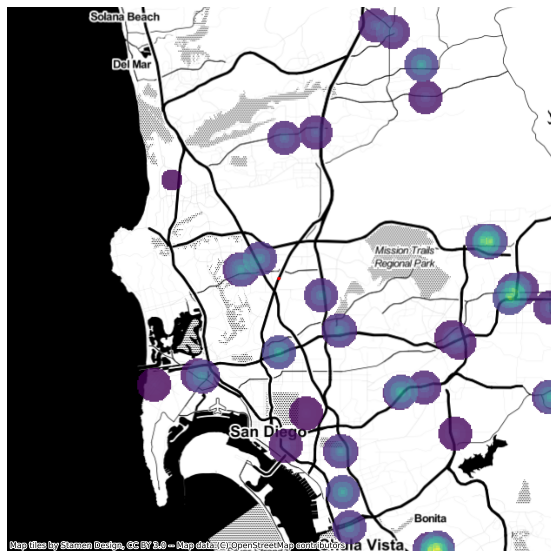

In [278]:
loc = 'Kearney Mesa, San Diego, CA'
#loc = gp(10)
p = rm.patch(loc,'gen_store+dept_store+hardware', size=200)
p = p.convolve("w_lin_2000")

p.show()


<AxesSubplot:>

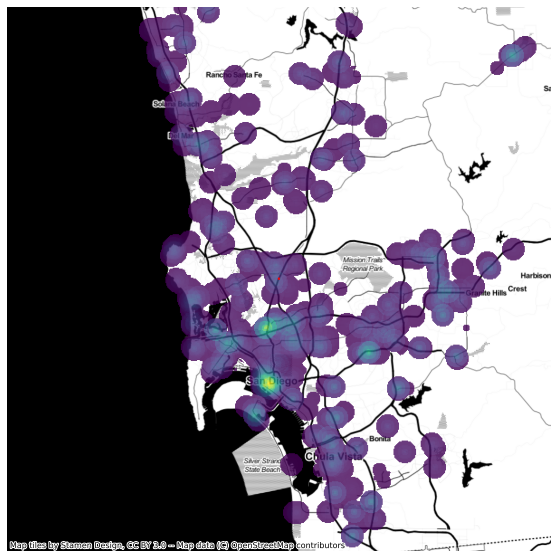

In [261]:
loc = 'Kearney Mesa, San Diego, CA'
#loc = gp(10)
p = rm.patch(loc,'2*snack_bev+bars', size=300)
p = p.convolve("w_lin_2000")

p.show()

<AxesSubplot:>

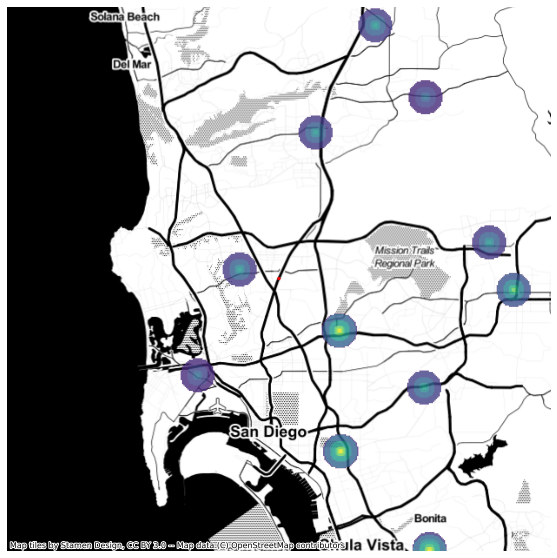

In [277]:
f="""
hardware.convolve("w_lin_2000").znorm
"""
loc = 'Kearney Mesa, San Diego, CA'

rm.patch(loc,f, size=200).show()

In [249]:
spv = p.peaks(as_points=True).sort_values('values', ascending = False)
p2 = rm.patch(spv.iloc[1].geometry, 'snack_bev')
print(' '.join(str(e) for e in list(p2.loc.ll)))
p2.convolve().show()

TypeError: peaks() got an unexpected keyword argument 'as_points'

<AxesSubplot:>

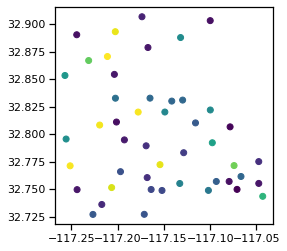

In [142]:
p.peaks().plot(column='values')

<AxesSubplot:>

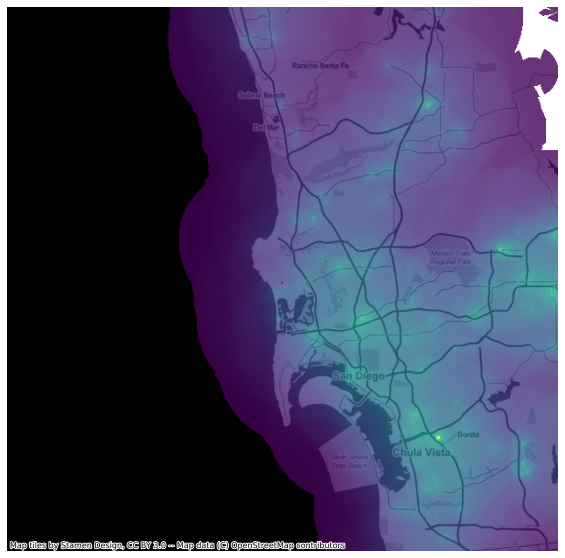

In [158]:
loc = '1370 Wilbur Ave, San Diego, Ca, 92109'
#loc = gp(10)
p = rm.patch(loc,'ls_restaurants', size=300)
p = p.convolve("w_r_inv")
p.show()

In [148]:
p.weight_names

['w_r_inv',
 'w_r2_inv',
 'w_r3_inv',
 'w_circle4',
 'w_lin_200',
 'w_lin_800',
 'w_lin_2000',
 'w_half',
 'w_zero']